In [3]:
signal = loadmat("nsrdb_16265_l1_s10(1).mat")
signal_with_TWA = loadmat("nsrdb_16265_l1_s10_with_TWA.mat")

In [4]:
signal_with_TWA['ecg_with_TWA']

array([[ 2.455,  2.875,  2.715, ..., -0.555,  1.475,  2.805]])

In [5]:
TWA = loadmat("AltWav_128hz.mat")
twa_signal = TWA["AltWav_128hz"]

(15,)


Text(0.5, 0, 'Time (s)')

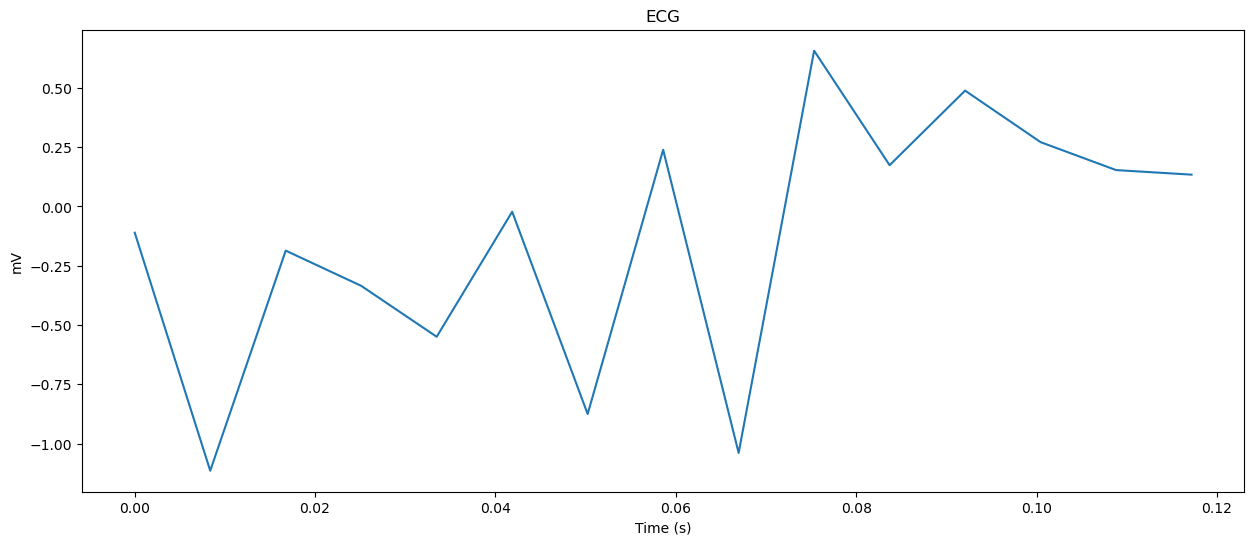

In [6]:
t = np.linspace(0,len(twa_signal[0])/128,len(twa_signal[0]))
print(t.shape)
plt.figure(figsize = (15,6))
plt.plot(t,twa_signal[0])
plt.title('ECG')
plt.ylabel('mV')
plt.xlabel('Time (s)')

In [47]:
#VER CUANTOS NSRDB hay
import os
carpeta = "DATA_TWA_Physionet_ControlECG"

# Inicializa el contador
contador_nsrdb = 0
lista_pacientes = []

# Recorre todos los archivos en la carpeta
for archivo in os.listdir(carpeta):
            # Comprueba si 'nsrdb' está en el título
    if 'nsrdb' in archivo:
        # Incrementa el contador si 'nsrdb' está presente
        contador_nsrdb += 1
        nombre_archivo = os.path.splitext(archivo)[0]  # Elimina la extensión del archivo
        numero_paciente = nombre_archivo.split("_")[1]  # Extrae el número de paciente
        # Comprueba si el paciente es nuevo y lo agrega a la lista si es así
        if numero_paciente not in lista_pacientes:
            lista_pacientes.append(numero_paciente)

# Muestra el recuento total de 'nsrdb' en los títulos de los archivos
print("Número total de veces que 'nsrdb' aparece en los títulos de los archivos:", contador_nsrdb)
print(lista_pacientes)

Número total de veces que 'nsrdb' aparece en los títulos de los archivos: 480
['16265', '16273', '16420', '16483', '16539', '16786', '17052', '17453', '18177', '18184', '19090', '19140']


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import splev, splrep
from scipy.io import loadmat
from scipy.signal import kaiserord, firwin, lfilter
import scipy.io as sio
import os
from scipy.io import loadmat
import random
import scipy
import json

In [7]:
print(signal)
print(type(signal))
print(signal_TWA)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Oct 21 11:36:08 2021', '__version__': '1.0', '__globals__': [], 'Fs': array([[128]], dtype=uint8), 'ecg': array([[ 2.455,  2.875,  2.715, ..., -0.555,  1.475,  2.805]]), 'header': array([[(array([[0]]), array(['nsrdb/16265'], dtype='<U11'), array(['[08:04:00.000]'], dtype='<U14'), array([[11730944]]), array(['25:27:28.000'], dtype='<U12'), array([[128]], dtype=uint32), array([[0]]), array(['16265.dat'], dtype='<U9'), array(['ECG1'], dtype='<U4'), array(['uncalibrated; assume 200 adu/mV'], dtype='<U31'), array([[-33]], dtype=int16), array(['212'], dtype='<U3'), array(['can be unbuffered'], dtype='<U17'), array(['12 bits'], dtype='<U7'), array([[0]], dtype=uint8), array([[0]], dtype=uint8), array([[15756]], dtype=uint16)),
        (array([[0]]), array(['nsrdb/16265'], dtype='<U11'), array(['[08:04:00.000]'], dtype='<U14'), array([[11730944]]), array(['25:27:28.000'], dtype='<U12'), array([[128]], dtype=uint32), array

NameError: name 'signal_TWA' is not defined

In [4]:
def bw_elimination(orig_ecg, fiducial_points, fs):
    """
    This function produces an estimate of the baseline wander using polynomial fitting by cubic splines.

    Parameters:
        orig_ecg (array): Samples of the original ECG.
        fiducial_points (array): Fiducial points.
        fs (float): Sampling frequency.

    Returns:
        bw_estimate (array): Baseline wander estimate.
    """

    # Define the duration before the fiducial point to consider as the isoelectric line (80 ms in this case)
    tPQ = 80e-3

    # Calculate the number of samples corresponding to the isoelectric line duration
    nPQ = int(tPQ * fs)

    # Get the number of fiducial points
    numb_fid_points = len(fiducial_points)

    if fiducial_points[0].any() - nPQ <= 0:
        # Create an array to store the knots for spline interpolation
        the_knots = np.array(np.zeros(numb_fid_points + 1))

        # Set the first knot to 1
        the_knots[0] = 1

        # Set the remaining knots as fiducial points minus the isoelectric line duration
        the_knots[1:numb_fid_points] = fiducial_points[1:numb_fid_points] - nPQ

        # Set the last knot as the length of the original ECG
        the_knots[numb_fid_points] = len(orig_ecg)

        # Convert the knots to indices (subtract 1 to account for zero-based indexing)
        the_knots = the_knots - 1
        the_knots = the_knots.astype(int)

        # Create an array 'c' to specify the continuity of the splines
        c = np.concatenate((the_knots[1], the_knots[1:numb_fid_points], the_knots[numb_fid_points-1]), axis=None)

        # Perform cubic spline interpolation using the knots and original ECG samples
        bw_estimate = splev(np.arange(len(orig_ecg)), splrep(the_knots, orig_ecg[c]), ext=0)

    else:
        # Create an array to store the knots for spline interpolation
        the_knots = np.array(np.zeros(numb_fid_points + 2))

        # Set the first knot to 1
        the_knots[0] = 1

        # Set the remaining knots as fiducial points minus the isoelectric line duration
        the_knots[1:numb_fid_points] = fiducial_points - nPQ

        # Set the last knot as the length of the original ECG
        the_knots[numb_fid_points] = len(orig_ecg)

        # Convert the knots to indices (subtract 1 to account for zero-based indexing)
        the_knots = the_knots - 1
        the_knots = the_knots.astype(int)

        # Create an array 'c' to specify the continuity of the splines
        c = np.concatenate((the_knots[1], the_knots[1:numb_fid_points], the_knots[numb_fid_points-1]), axis=None)

        # Perform cubic spline interpolation using the knots and fiducial points
        bw_estimate = splev(np.arange(len(orig_ecg)), splrep(the_knots, c), ext=0)

    # Return the estimated baseline wander
    return bw_estimate

In [5]:
def ST_T_delineation(ecg_signal, fiducial_points, fs):
    """
    This function delineates the ST-T complex using intervals of 300 ms length.
    The ST-T onset is chosen to be a variable distance from the QRS point that
    depends on the previous RR interval length.

    Parameters:
        ecg_signal (array): ECG signal.
        fiducial_points (array): R wave annotations.
        fs (float): Sampling frequency.

    Returns:
        ST_T_complexes (array): Matrix of ST-T complexes.
        ST_T_onset (array): Array of annotations of ST-T onset values.
    """

    RR_interval = np.diff(fiducial_points) / fs  # RR interval in seconds
    qi = 40 + (1.3 * np.sqrt(RR_interval * 1e3))  # ST-T onset from R in milliseconds

    # Handle different dimensions of qi array
    if qi.ndim == 1:
        qi = np.column_stack((qi[0], qi[:-1]))
    else:
        qi = np.column_stack((qi[:, 0], qi[:, :-1]))

    s = np.array(qi * 1e-3 * fs)
    fiducial_points = fiducial_points.transpose()

    ST_T_onset = fiducial_points + np.ceil(s) + 1  # ST-T onset in samples

    # Convert ST_T_onset to a list with individual values
    ST_T_onset = [matriz[0] for matriz in ST_T_onset]

    ST_T_interval = np.ceil(300e-3 * fs)  # ST-T interval length in number of samples

    ST_T_complexes = np.zeros((len(ST_T_onset)-1, int(ST_T_interval)))
    last_beat = ST_T_onset[-1]

    number_of_ST_T = len(ST_T_onset)
    for k in range(number_of_ST_T - 1):
        onset = int(np.ceil(ST_T_onset[k]))
        interval = onset + ST_T_interval

        if interval <= len(ecg_signal):
            # Ensure the start and end indices are within the array bounds
            onset_index = int(onset)
            interval_index = min(int(interval), len(ecg_signal))
            ST_T_complexes[k, :] = ecg_signal[onset_index:interval_index]

    return ST_T_complexes, ST_T_onset


In [6]:
def heartbeat_windowing(ST_T_complexes, ST_T_onset, WindSize, WindStep):
    """
    This function performs windowing to track alternans in an ECG.

    Parameters:
        ST_T_complexes (array): 2D matrix of ST-T segments of the signal.
        ST_T_onset (array): Onset of the ST-T segments.
        WindSize (int): Window length in beats.
        WindStep (int): Step size of the sliding process.

    Returns:
        ST_T_segments (array): Tensor with windowed ST-T complexes.
        ST_T_onset_by_segments (array): ST-T onset of the tensor.
        ST_T_dim (tuple): Dimensions of the incoming matrix of ST-T complexes.
    """

    Overlap = WindSize - WindStep
    ST_T_dim = np.shape(ST_T_complexes)

    NumbSegments = int((ST_T_dim[0] - Overlap) / WindStep)

    # Adjust the number of segments if necessary
    if NumbSegments == np.ceil((ST_T_dim[0] - Overlap) / WindStep):
        NumbSegments = NumbSegments - 1

    # Initialize tensors to store windowed ST-T complexes and ST-T onsets
    ST_T_segments = np.zeros((WindSize, ST_T_dim[1], NumbSegments))
    ST_T_onset_by_segments = np.zeros((NumbSegments, WindSize))

    index1 = 0
    index2 = WindSize

    # Perform windowing
    for k in range(NumbSegments):
        ST_T_segments[:, :, k] = ST_T_complexes[index1:index2, :]
        ST_T_onset_by_segments[k, :] = ST_T_onset[index1:index2]
        index1 = index1 + WindStep
        index2 = index2 + WindStep

    return ST_T_segments, ST_T_onset_by_segments, ST_T_dim

In [7]:
def background_subtraction(ST_T_ComplexTensor, WindSize):
    """
    This function performs the background subtraction of consecutive ST-T complexes.

    Parameters:
        ST_T_ComplexTensor (array): Tensor with windowed ST-T complexes. (3D array)
        WindSize (int): Size of the sliding window.

    Returns:
        ST_T_TensorBacGrElim (array): Tensor of windowed ST-T complexes after background subtraction.
    """

    # Create an array with the same shape as ST_T_ComplexTensor and fill it with zeros
    ST_T_TensorBacGrElim = np.zeros_like(ST_T_ComplexTensor)

    # Create a copy of the ST_T_ComplexTensor
    X = ST_T_ComplexTensor.copy()

    # Extract A pattern from X
    A_pattern = X[0::2, :]

    # Create an array with the same shape as A_pattern and fill it with zeros
    A_pattern_dis = np.zeros_like(A_pattern)

    # Assign values to A_pattern_dis by shifting A_pattern by one row
    A_pattern_dis[0:-1, :] = A_pattern[1:, :]
    A_pattern_dis[-1, :] = A_pattern[WindSize // 2 - 1, :]

    # Extract B pattern from X
    B_pattern = X[1::2, :]

    # Perform background subtraction by subtracting B_pattern from A_pattern rows and assigning the result to X
    X[0::2, :] = X[0::2, :] - B_pattern
    X[1::2, :] = X[1::2, :] - A_pattern_dis

    # Assign the modified X to ST_T_TensorBacGrElim
    ST_T_TensorBacGrElim = X

    # Return the resulting tensor after background subtraction
    return ST_T_TensorBacGrElim


In [8]:
def np_round(a, decimals=0):
    return np.round(a * 10 ** decimals) / 10 ** decimals


def ST_T_alignment(ST_T_complexes, ST_T_onset, ecg_signal, fs):
    """
    This function performs ST-T complex alignment using cross-correlation.

    Parameters:
        ST_T_complexes (array): 2D matrix of ST-T complexes.
        ST_T_onset (array): Onset of the ST-T complexes.
        ecg_signal (array): ECG signal.
        fs (float): Sampling frequency of the ECG signal.

    Returns:
        ST_T_complexes_align (array): Aligned ST-T complexes.
    """

    nbeats, nsamples = ST_T_complexes.shape
    ST_T_complexes_align = np.zeros(ST_T_complexes.shape)

    # Median template
    proto = np.median(ST_T_complexes, axis=0)

    # Calculate possible temporal variation from the initial position of each ST-T complex
    w = (0.03 * fs)  # samples
    w = np_round(w)
    w = int(w)

    for k in range(nbeats):
        ini = int(ST_T_onset[k])
        fin = int(ini + nsamples - 1)

        ecg_segment = ecg_signal[ini - w:fin + w]
        cross_corr = np.zeros(2 * w)

        for m in range(2 * w):
            temp = ecg_segment[m:-(2 * w) + m]
            # Adjust the dimension of temp if necessary
            if temp.shape[0] < proto.shape[0]:
                temp = np.append(temp, temp[-1])
            cc = np.corrcoef(proto, temp)
            cross_corr[m] = cc[1, 0]

        posMax = np.argmax(cross_corr)
        ST_T_complexes_align[k, :] = ecg_segment[posMax:posMax + nsamples]

    return ST_T_complexes_align

In [9]:
def background_subtraction(ST_T_ComplexTensor, WindSize):
    """
    This function performs the background subtraction of consecutive ST-T complexes.

    Parameters:
        ST_T_ComplexTensor (array): Tensor with windowed ST-T complexes. (3D array)
        WindSize (int): Size of the sliding window.

    Returns:
        ST_T_TensorBacGrElim (array): Tensor of windowed ST-T complexes after background subtraction.
    """

    # Create an array with the same shape as ST_T_ComplexTensor and fill it with zeros
    ST_T_TensorBacGrElim = np.zeros_like(ST_T_ComplexTensor)

    # Create a copy of the ST_T_ComplexTensor
    X = ST_T_ComplexTensor.copy()

    # Extract A pattern from X
    A_pattern = X[0::2, :]

    # Create an array with the same shape as A_pattern and fill it with zeros
    A_pattern_dis = np.zeros_like(A_pattern)

    # Assign values to A_pattern_dis by shifting A_pattern by one row
    A_pattern_dis[0:-1, :] = A_pattern[1:, :]
    A_pattern_dis[-1, :] = A_pattern[WindSize // 2 - 1, :]

    # Extract B pattern from X
    B_pattern = X[1::2, :]

    # Perform background subtraction by subtracting B_pattern from A_pattern rows and assigning the result to X
    X[0::2, :] = X[0::2, :] - B_pattern
    X[1::2, :] = X[1::2, :] - A_pattern_dis

    # Assign the modified X to ST_T_TensorBacGrElim
    ST_T_TensorBacGrElim = X

    # Return the resulting tensor after background subtraction
    return ST_T_TensorBacGrElim


In [10]:
def filtering_ST_T_segments(ST_T_ComplexTensor, Fs):
    """
    This function filters out the ST-T complexes to eliminate noise outside the TWA band (0.3-15 Hz).

    Parameters:
        ST_T_ComplexTensor (array): Tensor with windowed ST-T complexes.
        Fs (float): Working sampling frequency.

    Returns:
        ST_T_TensorFiltered (array): Tensor of windowed ST-T complexes after filtering.
    """

    # Design the filter
    nyquist = 0.5 * Fs
    passband_low = 0.3
    passband_high = 15.0
    ripple_db = 0.01
    ripple = 80.0

    # obtain numtaps and beta using kaiserord
    numtaps, beta = kaiserord(ripple, (passband_high - passband_low) / nyquist)

    # Compute the normalized cutoff frequencies
    cutoff_low = passband_low / nyquist
    cutoff_high = passband_high / nyquist

    # Compute the filter coefficients using firwin
    b = firwin(numtaps, [cutoff_low, cutoff_high], window=('kaiser', beta), pass_zero=False, scale=False)
    delay = int((numtaps + 1) / 2)
    b_wide = b

    # Initialize the filtered tensor
    ST_T_TensorFiltered = np.zeros_like(ST_T_ComplexTensor)

    # Iterate over segments, windows, and ST-T samples
    for k1 in range(ST_T_ComplexTensor.shape[2]):
        for k2 in range(ST_T_ComplexTensor.shape[0]):
            # Apply filtering to each window
            filtered_wide = lfilter(b_wide, 1, np.concatenate((ST_T_ComplexTensor[k2, :, k1], np.zeros(delay))))
            ST_T_TensorFiltered[k2, :, k1] = filtered_wide[delay:ST_T_ComplexTensor.shape[1] + delay]

    return ST_T_TensorFiltered


In [11]:
def include_TWA(clean_ecg, ST_T_onset, Alternan_wave, TWA_pattern, Type_of_inclusion):
    """
    The purpose of this function is the inclusion of an alternan wave into an ECG signal.

    Parameters:
        clean_ecg (numpy array): Array of integers corresponding to the ECG signal.
        ST_T_onset (numpy array): Array of annotations of ST-T onset values.
        Alternan_wave (numpy array): Waveform to perform TWA.
        TWA_pattern (numpy array): Array that describes the intervals where TWA are included.
        Type_of_inclusion (str): If this string is 'alternate', the alternan wave is included in every other beats with opposite sign.
                                 Otherwise, the alternan wave is only included every two beats.

    Returns:
        ecg_with_TWA (numpy array): ECG with TWA.
        Alt_waves (numpy array): Matrix whose rows consist of the alternan waves of ecg_with_TWA. It is subsequently used to compute the ANR.
    """
    #print("Type of inclusion:", Type_of_inclusion.lower())
    # Get the length of the Alternan wave
    L_AltWav = len(Alternan_wave)

    # Create a copy of the clean ECG signal
    ecg_with_TWA = clean_ecg.copy()

    # Initialize the Alt_waves matrix
    Alt_waves = np.zeros((len(ST_T_onset), L_AltWav))

    if Type_of_inclusion.lower() == 'alternate':
        # Include alternan wave in every other beat with opposite sign
        for k, onset in enumerate(ST_T_onset):
            if onset + L_AltWav <= (clean_ecg.shape[1]):
                Alt_waves[k, :] = TWA_pattern[k] * Alternan_wave * (-1) ** k
                #plt.plot(ecg_with_TWA[0, onset:onset + L_AltWav])
                ecg_with_TWA[0, onset:onset + L_AltWav] += Alt_waves[k, :]
                #plt.plot(ecg_with_TWA[0, onset:onset + L_AltWav])
                #plt.show()


    else:
        # Include alternan wave every two beats
        for k, onset in enumerate(ST_T_onset[1::2]):
            if onset + L_AltWav <= (clean_ecg.shape[1]):
                Alt_waves[k, :] = TWA_pattern[2 * k] * Alternan_wave
                ecg_with_TWA[0, onset:onset + L_AltWav] += Alt_waves[k, :]
    return ecg_with_TWA, Alt_waves

In [16]:
#print(ST_T_onset[1::2])
print(L_AltWav)

NameError: name 'L_AltWav' is not defined

In [12]:
def alternant_wave_inclusion(clean_ecg, TWA_pattern, type_of_inclusion, ST_T_onset, V_Alt_wave, Fs):
    """
    This function introduces an alternant wave according to the pattern
    defined by 'TWA_pattern' in the signal 'clean_ecg'.

    Input parameters:
        - clean_ecg: annotations of the R wave.
        - TWA_pattern: TWA pattern vector.
        - type_of_inclusion: manner TWA is included; can be 'alternate' or not.
        - ST_T_onset: onset of ST-T complexes of the ECG.
        - V_Alt_wave: alternant voltage.
        - Fs: sampling frequency

    Output parameters:
        - ecg_with_TWA: ECG signal with alternans.
        - Alt_waves: matrix whose rows consist of the alternan wave ecg_with_TWA.
        - Alternan_wave: waveform to perform TWA.
        - Onset_Valt: onset of TWA inclusion, having considered Jitter effect.
    """

    # Load the MATLAB file
    if Fs == 128:
        mat_data = scipy.io.loadmat('AltWav_128hz.mat')
    elif Fs == 250:
        mat_data = scipy.io.loadmat('AltWav_250hz.mat')
    else:
        mat_data = scipy.io.loadmat('AltWav_360hz.mat')

    AltWav = np.random.randint(1, 16)

    # Access the desired key
    if Fs == 128:
        Alternan_wave = mat_data['AltWav_128hz'][:, AltWav - 1]
    elif Fs == 250:
        Alternan_wave = mat_data['AltWav_250hz'][:, AltWav - 1]
    else:
        Alternan_wave = mat_data['AltWav_360hz'][:, AltWav - 1]
    

    if type_of_inclusion.lower() == 'alternate':
        alpha = V_Alt_wave / (np.max(np.abs(2 * Alternan_wave)) * 1e3)
    else:
        alpha = V_Alt_wave / (np.max(np.abs(Alternan_wave)) * 1e3)

    jitter_std = int(0.02 * Fs)  # Jitter effect standard deviation of 20 ms (0.02*Fs samples)

    Onset_Valt = (ST_T_onset + np.round(np.random.randn(len(ST_T_onset)) * jitter_std)).astype(int)

    # Perform TWA inclusion using the include_TWA function
    ecg_with_TWA, Alt_waves = include_TWA(clean_ecg, Onset_Valt, alpha * Alternan_wave, TWA_pattern, type_of_inclusion)

    V0 = np.max(np.abs(alpha * Alternan_wave)) * 1e3  # Alternan wave amplitude in microvolts
    if type_of_inclusion.lower() == 'alternate':
        V0 = 2 * V0

    return ecg_with_TWA, Alt_waves, Alternan_wave, alpha, Onset_Valt

# PRUEBA DE FUNCIONAMIENTO DE INSERCIÓN DE ALTERNANCIA

In [13]:
ecg = signal["ecg"]
print(ecg)
qrs = signal["qrs"]
qrs_ann = signal["qrs_ann"]
fs = signal["Fs"]
bw_estimate_clean = bw_elimination(ecg[0, :], qrs[0, :], fs)  #the fiducial points son simplmente esos picos R (están en el qrs de las señales)
clean_ecg_noBW = ecg[0, :] - bw_estimate_clean + np.mean(bw_estimate_clean)
clean_ecg_noBW
print(clean_ecg_noBW)
qrs.shape[1]

[[ 2.455  2.875  2.715 ... -0.555  1.475  2.805]]
[ 2.43398748  2.85252541  2.69111562 ... -0.61564907  1.41419353
  2.74398748]


C:\Users\alvar\AppData\Local\Temp\ipykernel_20884\2268194900.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nPQ = int(tPQ * fs)


496

In [14]:
ST_T_complexes, ST_T_onset = ST_T_delineation(clean_ecg_noBW, qrs, fs)

C:\Users\alvar\AppData\Local\Temp\ipykernel_20884\324144622.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ST_T_complexes = np.zeros((len(ST_T_onset)-1, int(ST_T_interval)))
C:\Users\alvar\AppData\Local\Temp\ipykernel_20884\324144622.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  interval_index = min(int(interval), len(ecg_signal))


In [15]:
clean_ecg = clean_ecg_noBW
type_of_inclusion = 'alternate'
V_Alt_wave = 35  # muV
Fs = 128  # Hz

# Obtain the 'TWA_pattern' and 'ST_T_onset' corresponding to the current signal
TWA_pattern = np.ones(qrs.shape[1])

# Generate the new signal with alternans using the 'alternant_wave_inclusion' function
ecg_with_TWA, alt_waves, Alternan_wave, alpha, Onset_Valt = alternant_wave_inclusion(
    ecg, TWA_pattern, type_of_inclusion, ST_T_onset, V_Alt_wave, fs)

C:\Users\alvar\AppData\Local\Temp\ipykernel_20884\2295270263.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  jitter_std = int(0.02 * Fs)  # Jitter effect standard deviation of 20 ms (0.02*Fs samples)


In [16]:
print(ecg_with_TWA)

[[ 2.455  2.875  2.715 ... -0.555  1.475  2.805]]


# PREPROCESSING FOR 1 SIGNAL

In [17]:
fs = signal["Fs"]
print(fs)
ecg = signal["ecg"]
ecg1 = signal_with_TWA["ecg_with_TWA"]
print(ecg1)
qrs = signal["qrs"]
qrs_ann = signal["qrs_ann"]
print(len(qrs[0]))
print(len(qrs_ann[0]))

qrs1= signal_with_TWA["qrs"]

[[128]]
[[ 2.455  2.875  2.715 ... -0.555  1.475  2.805]]
496
496


In [18]:
ecg[0]

array([ 2.455,  2.875,  2.715, ..., -0.555,  1.475,  2.805])

In [19]:
print(ecg[0])
print(ecg[0].shape)

[ 2.455  2.875  2.715 ... -0.555  1.475  2.805]
(39497,)


(39497, 1)


Text(0.5, 0, 'Time (s)')

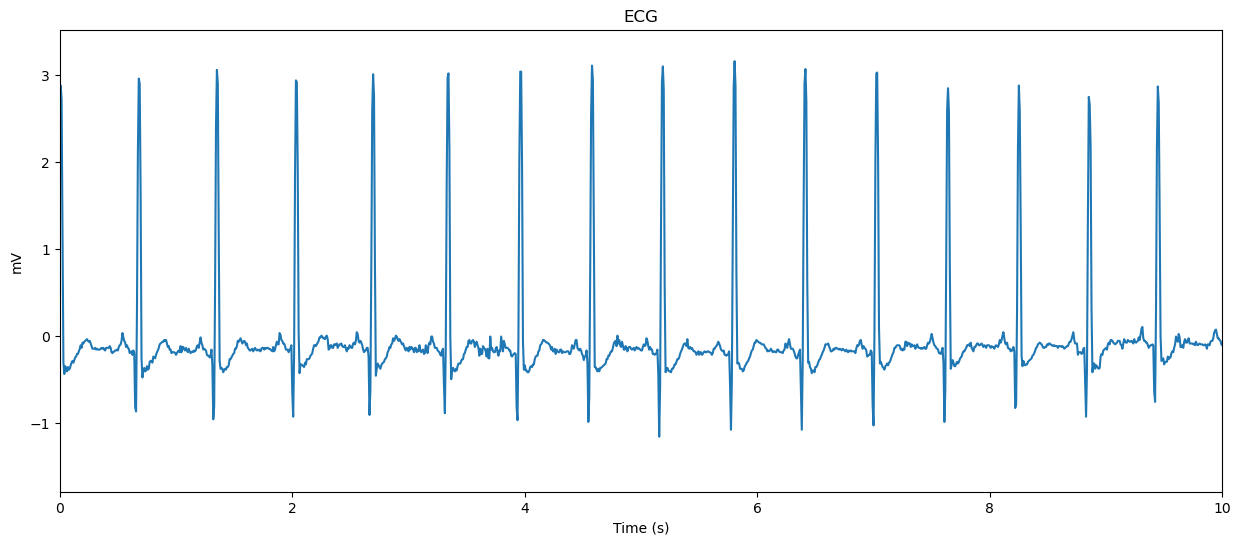

In [20]:
t = np.linspace(0,len(ecg[0])/fs[0],len(ecg[0]))
print(t.shape)
plt.figure(figsize = (15,6))
plt.plot(t,ecg[0])
plt.xlim(0,10)
plt.title('ECG')
plt.ylabel('mV')
plt.xlabel('Time (s)')

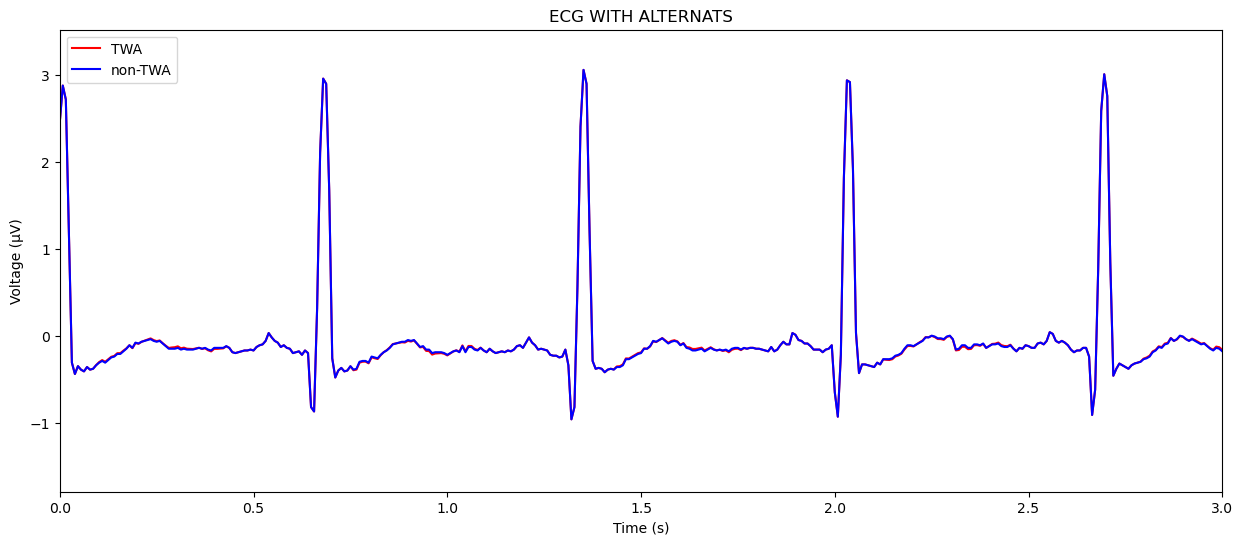

In [21]:
t = np.linspace(0,len(ecg1[0])/fs[0],len(ecg1[0]))
t2 = np.linspace(0,len(ecg[0])/fs[0],len(ecg[0]))
plt.figure(figsize = (15,6))
plt.plot(t,ecg1[0], "r", label = "TWA")
plt.plot(t2, ecg[0], "b", label = "non-TWA") 
plt.xlim(0,3)
plt.title('ECG WITH ALTERNATS')
plt.ylabel('Voltage (\u03BCV)')
plt.xlabel('Time (s)')
plt.legend()

# BASELINE WANDER REMOVAL

In [22]:
bw_estimate_clean = bw_elimination(ecg[0, :], qrs[0, :], fs)  #the fiducial points son simplmente esos picos R (están en el qrs de las señales)
clean_ecg_noBW = ecg[0, :] - bw_estimate_clean + np.mean(bw_estimate_clean)
clean_ecg_noBW[0]
ecg.shape

C:\Users\alvar\AppData\Local\Temp\ipykernel_20884\2268194900.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nPQ = int(tPQ * fs)


(1, 39497)

In [23]:
bw_estimate_clean1 = bw_elimination(ecg1[0, :], qrs1[0, :], fs)
clean_ecg_noBW1 = ecg1[0, :] - bw_estimate_clean1 + np.mean(bw_estimate_clean1)
clean_ecg_noBW1.shape

C:\Users\alvar\AppData\Local\Temp\ipykernel_20884\2268194900.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nPQ = int(tPQ * fs)


(39497,)

(39497, 1)


Text(0.5, 0, 'Time (s)')

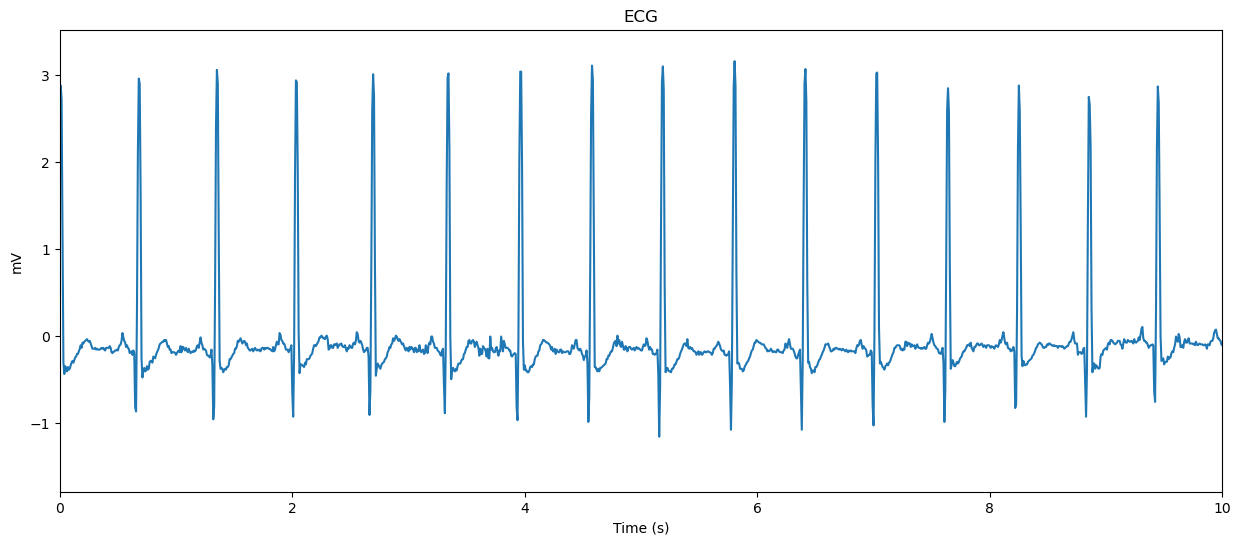

In [24]:
t = np.linspace(0,len(ecg[0])/fs[0],len(ecg[0]))
print(t.shape)
plt.figure(figsize = (15,6))
plt.plot(t,ecg[0])
plt.xlim(0,10)
plt.title('ECG')
plt.ylabel('mV')
plt.xlabel('Time (s)')

(39497, 1)


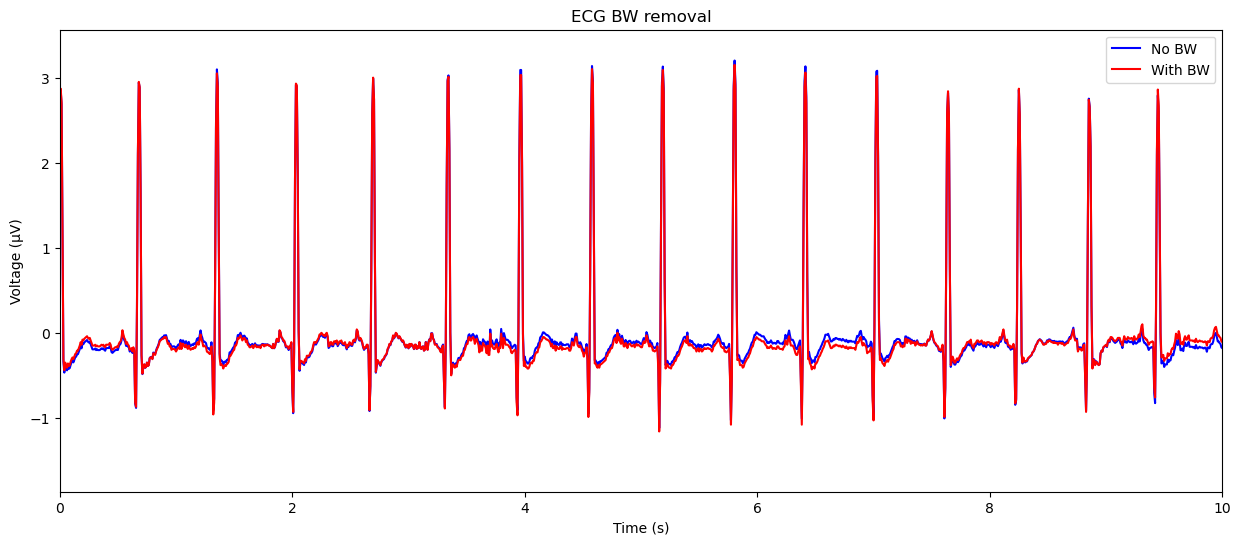

In [25]:
t = np.linspace(0,len(clean_ecg_noBW)/fs[0],len(clean_ecg_noBW))
print(t.shape)
plt.figure(figsize = (15,6))
plt.plot(t,clean_ecg_noBW, color = "b", label = "No BW")
plt.plot(t,ecg[0], color = "r", label = "With BW")
plt.xlim(0,10)
plt.title('ECG BW removal')
plt.ylabel('Voltage (\u03BCV)')
plt.xlabel('Time (s)')
plt.legend()

# ST-SEGMENTS OBTANTAION

In [26]:
ST_T_complexes, ST_T_onset = ST_T_delineation(clean_ecg_noBW, qrs, fs)
ST_T_complexes1, ST_T_onset1 = ST_T_delineation(clean_ecg_noBW1, qrs1, fs)  #WITH ALTERNAN

C:\Users\alvar\AppData\Local\Temp\ipykernel_20884\324144622.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ST_T_complexes = np.zeros((len(ST_T_onset)-1, int(ST_T_interval)))
C:\Users\alvar\AppData\Local\Temp\ipykernel_20884\324144622.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  interval_index = min(int(interval), len(ecg_signal))


In [28]:
print(ST_T_complexes)
print(ST_T_complexes.shape)
print(len(ST_T_complexes[0]))
#print("St:onset", ST_T_onset)

[[-0.34109506 -0.32191942 -0.3426985  ... -0.19609605 -0.20563006
  -0.17513821]
 [-0.37277858 -0.29167928 -0.28058053 ... -0.14740459 -0.08666505
  -0.08594548]
 [-0.31335114 -0.31396988 -0.29460823 ... -0.14334587 -0.16426172
  -0.13517382]
 ...
 [-0.29189852 -0.2827497  -0.26361118 ... -0.14819646 -0.13934498
  -0.1304996 ]
 [-0.31292437 -0.30408861 -0.2452426  ... -0.15379991 -0.13419122
  -0.1545492 ]
 [-0.33536333 -0.30458573 -0.2737912  ... -0.13438279 -0.12367318
  -0.12298536]]
(495, 39)
39


(39, 1)


Text(0.5, 0, 'Time (s)')

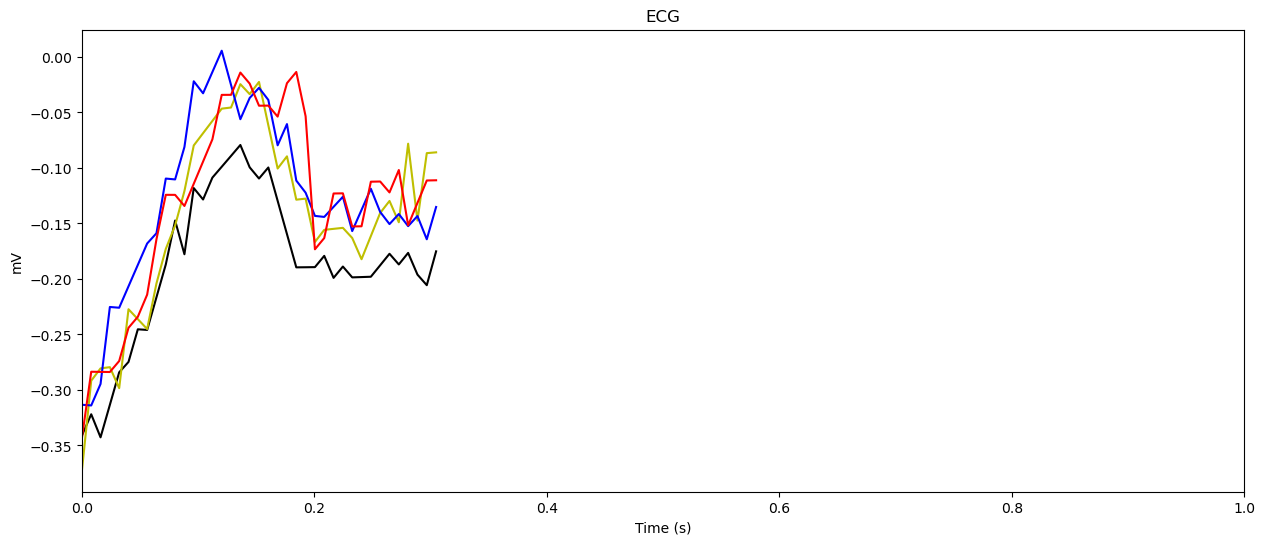

In [29]:
t = np.linspace(0,len(ST_T_complexes[0])/fs[0],len(ST_T_complexes[0]))
print(t.shape)
plt.figure(figsize = (15,6))
plt.plot(t,ST_T_complexes[0], color = "black")
plt.plot(t,ST_T_complexes[1], color = "y")
plt.plot(t,ST_T_complexes[2], color = "blue")
plt.plot(t,ST_T_complexes[3], color = "red")

plt.xlim(0,1)
plt.title('ECG')
plt.ylabel('mV')
plt.xlabel('Time (s)')

(39, 1)


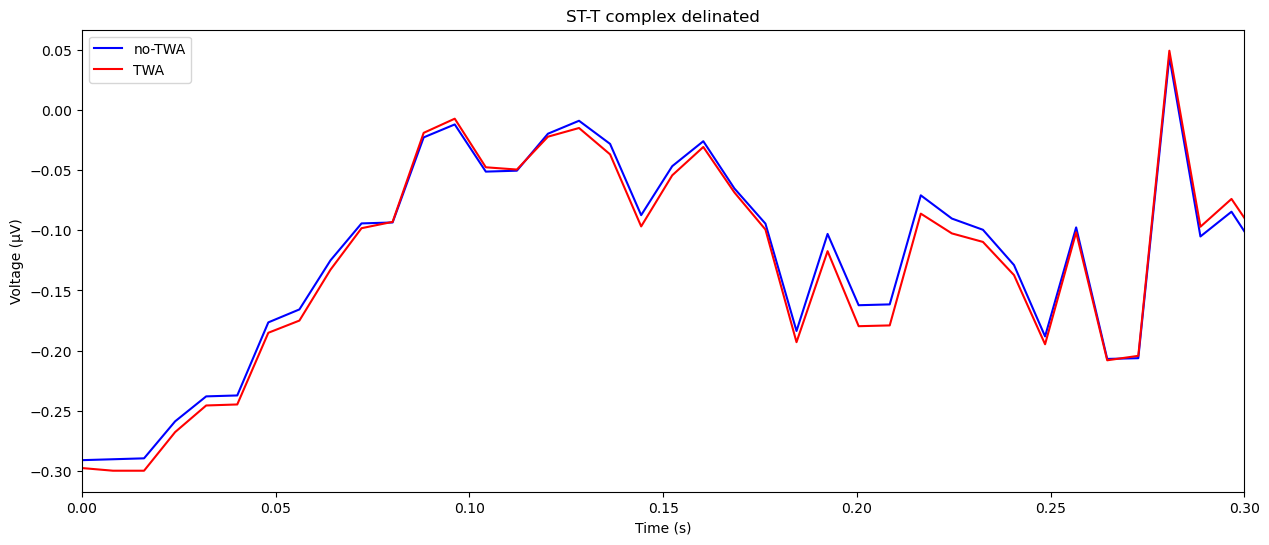

In [30]:
t = np.linspace(0,len(ST_T_complexes1[0])/fs[0],len(ST_T_complexes1[0]))
t1 = np.linspace(0,len(ST_T_complexes[0])/fs[0],len(ST_T_complexes[0]))
print(t.shape)
plt.figure(figsize = (15,6))
plt.plot(t1,ST_T_complexes[5], color = "blue", label = "no-TWA") #5 #0
plt.plot(t,ST_T_complexes1[5], color = "red", label = "TWA")
plt.xlim(0,0.3)
plt.title('ST-T complex delinated')
plt.ylabel('Voltage (\u03BCV)')
plt.xlabel('Time (s)')
plt.legend()


## WITH ALTERNANTS

(39, 1)


Text(0.5, 0, 'Time (s)')

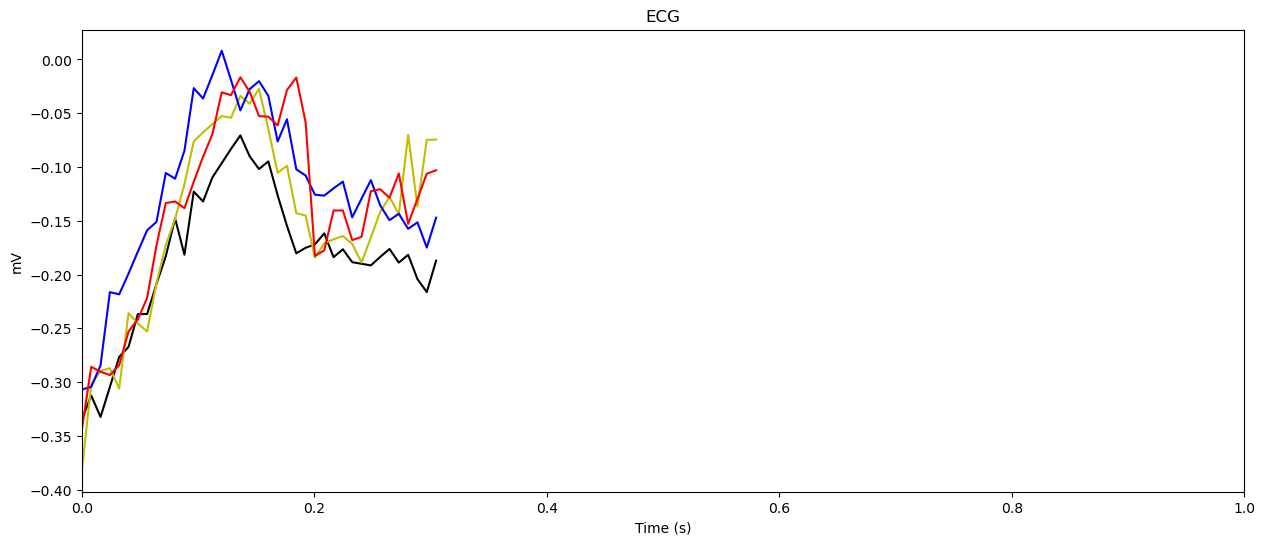

In [31]:
t = np.linspace(0,len(ST_T_complexes1[0])/fs[0],len(ST_T_complexes1[0]))
print(t.shape)
plt.figure(figsize = (15,6))
plt.plot(t,ST_T_complexes1[0], color = "black")
plt.plot(t,ST_T_complexes1[1], color = "y")
plt.plot(t,ST_T_complexes1[2], color = "blue")
plt.plot(t,ST_T_complexes1[3], color = "red")

plt.xlim(0,1)
plt.title('ECG')
plt.ylabel('mV')
plt.xlabel('Time (s)')

## WINDOWING

Formamos una estructura--> 
- la primera dimension son los latidos que eliges, en este caso de 32 ( es un tamaño que se dice correcto para las alternancias)
- La segunda es el número de muestras en cada latido
- la tercera son cuantos bloques de esos tienes, en este caso son 58 bloques de 32 latidos ( ES DECIR CUANTOS GRUPOS DE 32 TENEMOS)


In [32]:
WindSize = 32  # Analyze in blocks of 32 beats
WindStep = 8   # Each window contains 8 new beats---->  A menos windStep mayor coste computacional pero quizás mejor análisis
ST_T_segments, ST_T_onset_by_segments, _ = heartbeat_windowing(ST_T_complexes, ST_T_onset, WindSize, WindStep)
ST_T_segments1, ST_T_onset_by_segments1, _ = heartbeat_windowing(ST_T_complexes1, ST_T_onset1, WindSize, WindStep)

In [33]:
print(ST_T_segments.shape)
print(ST_T_segments)
print(len(ST_T_segments[0]))
#ST_T_segments[0].shape     #EL PRIMER BLOQUE DE LATIDOS DE LOS 32 QUE HAY 
#len(ST_T_segments[0:0])

(32, 39, 58)
[[[-0.34109506 -0.33357717 -0.32620608 ... -0.31390702 -0.28533978
   -0.31186729]
  [-0.32191942 -0.31346958 -0.29624289 ... -0.29470767 -0.26534799
   -0.30224676]
  [-0.3426985  -0.2833619  -0.26627881 ... -0.28550517 -0.26536087
   -0.26263153]
  ...
  [-0.19609605 -0.13933402 -0.13400537 ... -0.14892046 -0.10973653
   -0.18479033]
  [-0.20563006 -0.13919546 -0.13374848 ... -0.16944666 -0.13001511
   -0.185001  ]
  [-0.17513821 -0.12905522 -0.15347574 ... -0.15996052 -0.13030421
   -0.18519642]]

 [[-0.37277858 -0.30143535 -0.30749664 ... -0.29876536 -0.28876641
   -0.30964817]
  [-0.29167928 -0.28120213 -0.30645555 ... -0.27873609 -0.25941721
   -0.29921811]
  [-0.28058053 -0.26096692 -0.27540031 ... -0.27869501 -0.2500705
   -0.26878198]
  ...
  [-0.14740459 -0.09196718 -0.14394536 ... -0.14170073 -0.11046428
   -0.10583888]
  [-0.08666505 -0.09167828 -0.15264577 ... -0.17137257 -0.13091364
   -0.11567546]
  [-0.08594548 -0.1113883  -0.15134637 ... -0.16103983 -0.151

[-0.34109506 -0.32191942 -0.3426985  -0.31343285 -0.28412299 -0.27476947
 -0.24537282 -0.24593359 -0.21645232 -0.18692954 -0.1473658  -0.17776163
 -0.11811757 -0.12843417 -0.10871195 -0.09895147 -0.08915326 -0.07931785
 -0.09944579 -0.10953762 -0.09959388 -0.1296151  -0.15960183 -0.18955461
 -0.18947396 -0.18936044 -0.17921458 -0.19903692 -0.18882801 -0.19858837
 -0.19831855 -0.19801909 -0.18769053 -0.17733341 -0.18694826 -0.17653563
 -0.19609605 -0.20563006 -0.17513821]
[-0.30829362 -0.28784949 -0.24740266 -0.2669538  -0.21650359 -0.17605269
 -0.14560179 -0.14515157 -0.13470269 -0.09425583 -0.06381167 -0.07337088
 -0.07293415 -0.08250213 -0.09207552 -0.12165498 -0.1212412  -0.08083484
 -0.08043658 -0.0700471  -0.07966708 -0.07929718 -0.09893809 -0.11859047
 -0.13825502 -0.14793239 -0.14762327 -0.14732833 -0.12704824 -0.13678369
 -0.15653535 -0.1463039  -0.15609    -0.12589433 -0.14571758 -0.16556041
 -0.1354235  -0.14530753 -0.13521318]
[-0.30829362 -0.28784949 -0.24740266 -0.2669538 

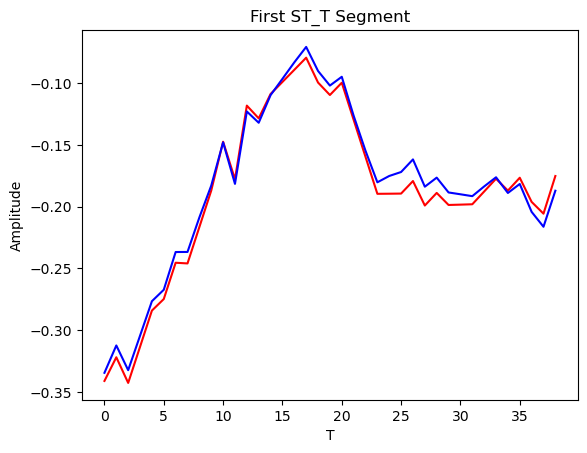

In [34]:
#transpose ST_T_complexes

ST_T_segments_transpose = np.transpose(ST_T_segments)   # ESTO SE HACE PARA PODER PINTARLOS---> ¿QUIZÁS SE CONSIGA HACER SIN TRANSPONER?
print(ST_T_segments[0,:,0])   # if i have [0,:,1]---> I get the second complex of the first segment
print(ST_T_segments_transpose[57,:,12])    #I get from segment 58, the 12th complex
print(ST_T_segments[12,:,57])   #THE SAME AS PREVIOUS

#print the first complex from the first segment
plt.plot(ST_T_segments[0,:,0], color = 'red')
plt.plot(ST_T_segments1[0,:,0], color = "blue")

print(ST_T_segments_transpose.shape)
plt.xlabel('T')
plt.ylabel('Amplitude')


plt.title('First ST_T Segment')

plt.show()

In [35]:
ST_T_segments[0].shape
ST_T_segments_aligned[0].shape

NameError: name 'ST_T_segments_aligned' is not defined

ALINEATION----> LOS ALINEA PARA QUE COINCIDAN LOS LOS PUNTOS ELÉCTRICOS

## ST_T SEGMENTS ALINEATION

In [36]:
# 4.Alineación de los segmentos ST-T

WindSize = 32
NumbSegments = ST_T_segments.shape[2]
NumbSegments1 = ST_T_segments1.shape[2]
print(NumbSegments)
print(NumbSegments1)

# Step 1: Create an array of zeros to store the aligned ST-T segments
ST_T_segments_aligned = np.zeros((WindSize, ST_T_segments.shape[1], NumbSegments))
#Creamos un array de zeros to store---> WindSize = 32, El numero de complejos que es 39 y los segmentos que son 58
ST_T_segments_aligned1 = np.zeros((WindSize, ST_T_segments1.shape[1], NumbSegments))


58
58


In [37]:
# Step 2: Iterate over each segment
for k in range(NumbSegments):
    # Step 3: Align the ST-T segment using ST_T_alignment function
    aligned_segment = ST_T_alignment(ST_T_segments[:,:,k], ST_T_onset_by_segments[k,:], clean_ecg_noBW, fs)

    # Step 4: Store the aligned segment in the corresponding position of ST_T_segments_aligned
    ST_T_segments_aligned[:,:,k] = aligned_segment
for k in range(NumbSegments1):
    # Step 3: Align the ST-T segment using ST_T_alignment function
    aligned_segment1 = ST_T_alignment(ST_T_segments1[:,:,k], ST_T_onset_by_segments1[k,:], clean_ecg_noBW1, fs)

    # Step 4: Store the aligned segment in the corresponding position of ST_T_segments_aligned
    ST_T_segments_aligned1[:,:,k] = aligned_segment

C:\Users\alvar\AppData\Local\Temp\ipykernel_20884\2114414957.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  w = int(w)


In [38]:
ST_T_segments_aligned.shape

(32, 39, 58)

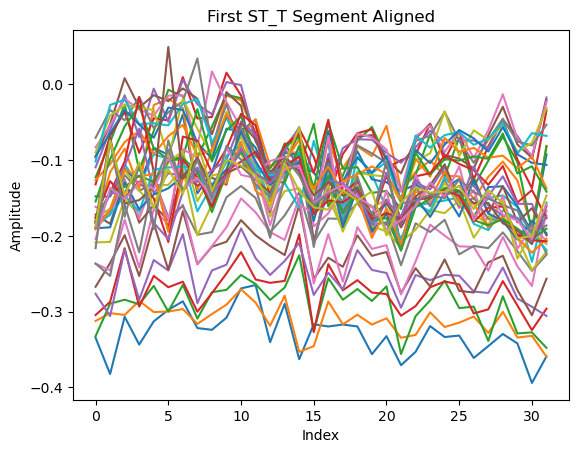

In [39]:
plt.plot(ST_T_segments1[:,:,0])

plt.xlabel('Index')
plt.ylabel('Amplitude')


plt.title('First ST_T Segment Aligned')


plt.show()

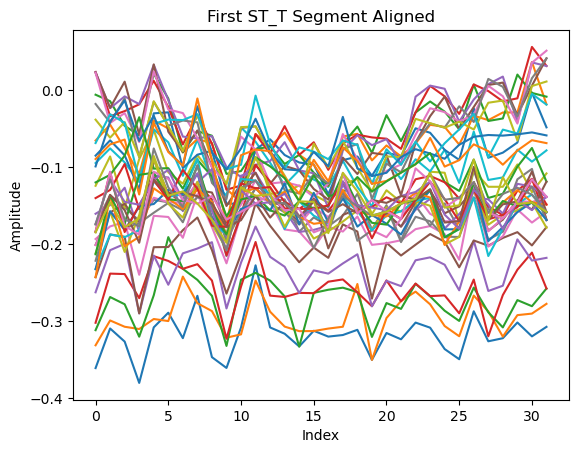

In [40]:
#print the first complex from the first segment
#plt.plot(ST_T_segments_aligned[0,:,0], color = 'red')
plt.plot(ST_T_segments_aligned1[:,:,0])

plt.xlabel('Index')
plt.ylabel('Amplitude')


plt.title('First ST_T Segment Aligned')


plt.show()

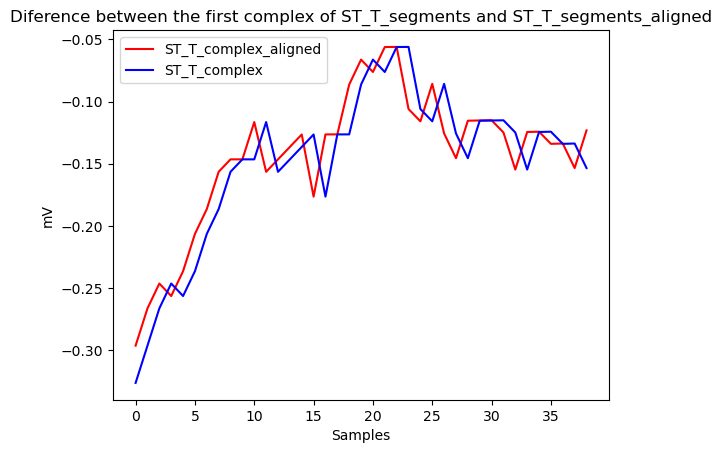

In [51]:
#ver diferencia entre ST_T_segments y ST_T_segments_aligned
#deberia ser minima o no haber
plt.figure()
plt.plot(ST_T_segments_aligned[0,:,2], color='red', label='ST_T_complex_aligned')
plt.plot(ST_T_segments[0,:,2], color='blue', label='ST_T_complex')


plt.title('Diference between the first complex of ST_T_segments and ST_T_segments_aligned')
plt.ylabel('mV')
plt.xlabel('Samples')
plt.legend()
plt.show()

## BACKGROUND SUBSTRACTION

In [52]:
# 5. Background Subtraction (restar los latidos de 2 en 2 para quedarnos solamente con la parte alternante si la hay)
##hace la diferencia entre 2 compejos ST_T contiguos.

WindSize = 32
NumbSegments = ST_T_segments_aligned.shape[2]

ST_T_dif = np.zeros_like(ST_T_segments_aligned)
ST_T_dif1 = np.zeros_like(ST_T_segments_aligned1)

In [53]:
for k in range(NumbSegments-1):
    ST_T_TensorBacGrElim = background_subtraction(ST_T_segments_aligned[:,:,k], WindSize)
    ST_T_dif[:,:,k] = ST_T_TensorBacGrElim
for k in range(NumbSegments1-1):
    ST_T_TensorBacGrElim1 = background_subtraction(ST_T_segments_aligned1[:,:,k], WindSize)
    ST_T_dif1[:,:,k] = ST_T_TensorBacGrElim1

In [54]:
ST_T_dif.shape
#preguntar por que no debería ser la mitad (tipo si restamos un complejo con otro--> Deberiamos tener la mitad?)

(32, 39, 58)

In [55]:
print(ST_T_dif[:,:,0])

[[ 0.03168352 -0.03024015 -0.06211797 ... -0.04869146 -0.11896502
  -0.08919274]
 [-0.03002592  0.02167186  0.03338935 ...  0.00502233  0.05668082
   0.07831624]
 [-0.05901682 -0.02950359 -0.04002471 ... -0.04131634 -0.04243397
  -0.03355134]
 ...
 [-0.00797456  0.00182941 -0.01835528 ...  0.01012593  0.02016282
  -0.00979897]
 [ 0.04619651  0.02593075  0.04566219 ... -0.01292054 -0.0230916
  -0.03325429]
 [-0.04619651 -0.02593075 -0.04566219 ...  0.01292054  0.0230916
   0.03325429]]


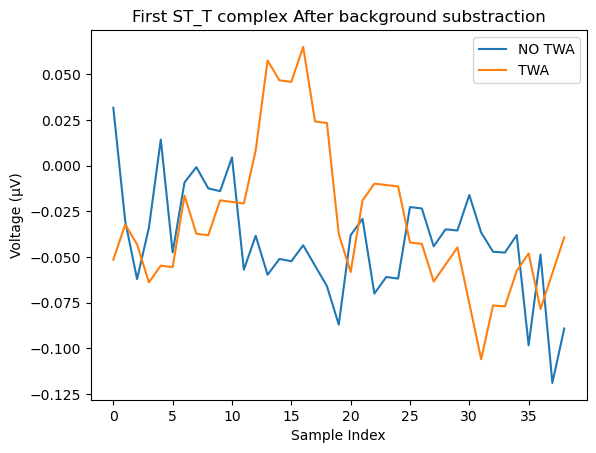

In [57]:
plt.figure
plt.plot(ST_T_dif[0,:,0], label = "NO TWA")
plt.plot(ST_T_dif1[0,:,0], label = "TWA")
plt.xlabel('Sample Index')
plt.ylabel('Voltage (\u03BCV)')
plt.title('First ST_T complex After background substraction') #EL OBJEIVO SERÍA QUEDARNOS SOLO CON LA ALTERNANCIA
plt.legend()
plt.show()

# LINEAR FILTERING

In [58]:
##The filter will retain frequencies within the range of 0.3 to 15 Hz, where the alternans is present.
fs = 128
ST_T_dif_filtered = filtering_ST_T_segments(ST_T_dif, fs)

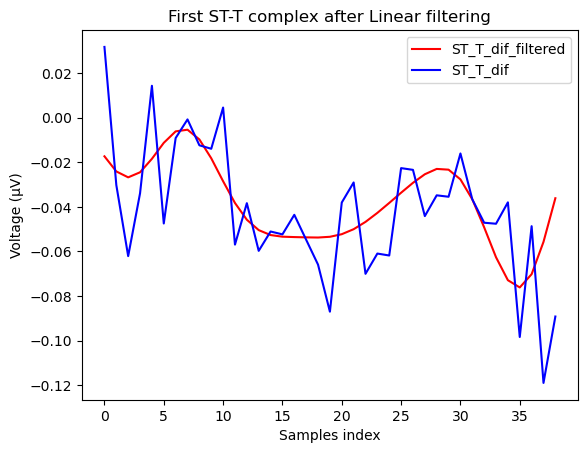

In [59]:
#print the first complex from the first segment
plt.plot(ST_T_dif_filtered[0,:,0], color = 'red', label='ST_T_dif_filtered')
plt.plot(ST_T_dif[0,:,0], color = 'blue', label='ST_T_dif')

plt.title("First ST-T complex after Linear filtering")
plt.legend()
plt.xlabel("Samples index")
plt.ylabel("Voltage (\u03BCV)")
plt.show()
#smoother

In [48]:
SIGNAL_COMPLETE = ST_T_dif_filtered
# 32 COMLEXES OF 39 SAMPLES IN EACH OF THE 58 SEGMENTS---> THIS WOULD BE ONLY ONE SIGNAL FROM A PATIENT
print(SIGNAL_COMPLETE.shape)

(32, 39, 58)


# SPECTRAL METHOD AND TIME METHOD

In [49]:
def SM_TWA(M_Wind):
    """
    This function applies the enhanced spectral method (SM) explained in:

    MG Fernández-Calvillo et all, "Machine Learning approach for TWA detection relying on ensemble data design," Heliyon, Vol. 9, no. 1, Jan 2023.

    The method can work over either ST-T complexes or differential ST-T complexes. The SM estimates the power spectrum density of each beat
    series Sj by means of the periodogram:

             Pj=(1/M)|FFT({Sj})|^2

    where M stands for the number of heartbeats taken to apply the SM. The averaged power spectrum of the all beat series is:

                 P=(1/N)?Pj

    Parameters:
        M_Wind (array): Array containing the signal corresponding to one window.

    Returns:
        AverPSD (array): Averaged spectrum.
        K_score (float): TWAR value.
        Valt (float): Estimated alternant wave.
    """

    M = len(M_Wind)#['0'])
    N = len(M_Wind[0])#['0'][0])

    L = 2 ** np.ceil(np.log2(M))  # Resolution of the FFT.


    #PSD_BeatSeries = np.abs(np.fft.fft(M_Wind['0'], L, axis=0)) ** 2
    PSD_BeatSeries = np.abs(np.fft.fft(M_Wind, L, axis=0)) ** 2
    AverPSD = np.mean(PSD_BeatSeries, axis=1) / (M * N)

    noise_band = AverPSD[int(0.66 * ((L / 2)-1)):int(0.96 * ((L / 2)-1))]


    noise_mean = np.mean(noise_band)

    noise_std = np.std(noise_band)

    T = AverPSD[1 + int(((L / 2)-1))]

    K_score = (T - noise_mean) / noise_std

    if K_score > 0:
        Valt = np.sqrt(T - noise_mean) / np.sqrt(M)  # The division by sqrt(M) is to compensate a weighting factor.
    else:
        Valt = 0



    return AverPSD, K_score, Valt


In [24]:
# Create list to store K-scores
K_scores = np.zeros(len(SIGNAL_COMPLETE[:,:,0]))
print(K_scores)
print(len(K_scores))
# Perform analysis

print(SIGNAL_COMPLETE[:,:,0][0])
print(SIGNAL_COMPLETE[0,:,0])

#len(SIGNAL_COMPLETE["0"])
final_k = []
Numb_segments = SIGNAL_COMPLETE.shape[2]
for window in range(0,Numb_segments-1):
    AverPSD, k_score, _ = SM_TWA(SIGNAL_COMPLETE[:,:,window])
    print(k_score)
    final_k.append(k_score)

print("eeee", np.mean(final_k))
    

k = SM_TWA(SIGNAL_COMPLETE[:,:,1])
print(len(k[0]))

print(k[1])

NameError: name 'SIGNAL_COMPLETE' is not defined

LA FUNCION DEL METDODO SPECTRAL RECOGE UN BLOQUE ( ES DECIR [:,:,0] PARA EL PRIMER BLOQUE), hay que pasarlos de foma que los complejos ST_T sean filas. 

Para cada uno de estos bloques te devuelve unvalor de kscore---> Potencia que hay en la frecuencia cada dos latidos.
Se estableción un umbral de 3 que te dfine si hay alternancia o no. 
Al ser un fenomeno transitorio conseguiremos tener si hay alternancia o no por complex.

Para el método temporal recive lo mismo, devolviendo 

# PROBAR CON TODA LA BASE DE DATOS

In [ ]:
#import zipfile as zf
#files = zf.ZipFile("Data_TWA_Physionet_ControlECG.zip", 'r')
#files.extractall('SIGNALS_COMPLETE')
#files.close()

In [11]:
import os
ALL_SIGNALS = []
# Ruta de la carpeta
carpeta = "Data_TWA_Physionet_ControlECG"

# Lista todos los archivos y carpetas en la carpeta
elementos = os.listdir(carpeta)

# Itera sobre los elementos
for index, elemento in enumerate(elementos):
    if index == 0:
        pass
    else:
        print(elemento)
        aux_dict = {}
        # Ruta completa del elemento
        ruta_completa = os.path.join(carpeta, elemento)
        try:
            #print(elemento)
            signal = loadmat(ruta_completa)
            aux_dict.update({"Name": elemento, "Fs": signal["Fs"], "Qrs": signal["qrs"], "Ecg": signal["ecg"],
                             "Qrs_ann": signal['qrs_ann'] })
            ALL_SIGNALS.append(aux_dict)
        except ValueError:   #This is because there might be files which are not mat type (docx)
            pass


            

edb_106_l1_s1.mat
edb_106_l1_s2.mat
edb_106_l1_s4.mat
edb_106_l2_s1.mat
edb_106_l2_s2.mat
edb_106_l2_s3.mat
edb_115_l1_s1.mat
edb_115_l1_s2.mat
edb_122_l2_s1.mat
edb_122_l2_s4.mat
edb_122_l2_s5.mat
edb_124_l2_s1.mat
edb_124_l2_s2.mat
edb_124_l2_s6.mat
edb_1301_l1_s1.mat
edb_1301_l1_s2.mat
edb_1301_l1_s3.mat
edb_1301_l1_s4.mat
edb_1301_l2_s2.mat
edb_1301_l2_s3.mat
edb_154_l1_s1.mat
edb_154_l1_s2.mat
edb_154_l1_s3.mat
edb_154_l1_s5.mat
edb_154_l1_s6.mat
edb_154_l1_s7.mat
edb_154_l2_s1.mat
edb_154_l2_s2.mat
edb_210_l2_s1.mat
edb_210_l2_s2.mat
edb_210_l2_s3.mat
edb_210_l2_s4.mat
edb_210_l2_s6.mat
edb_210_l2_s7.mat
edb_302_l1_s1.mat
edb_302_l1_s2.mat
edb_302_l2_s1.mat
edb_303_l1_s1.mat
edb_303_l1_s2.mat
edb_303_l2_s1.mat
edb_303_l2_s2.mat
edb_303_l2_s3.mat
edb_303_l2_s4.mat
edb_304_l1_s1.mat
edb_304_l1_s3.mat
edb_304_l1_s4.mat
edb_304_l2_s1.mat
edb_304_l2_s3.mat
edb_403_l1_s1.mat
edb_403_l1_s2.mat
edb_403_l1_s3.mat
edb_403_l1_s4.mat
edb_403_l1_s5.mat
edb_403_l1_s6.mat
edb_403_l1_s7.mat
edb_

In [51]:
All_signals = ALL_SIGNALS   #This is just to have something that always states the same

In [52]:
print(All_signals[500])

{'Name': 'nsrdb_18184_l2_s7.mat', 'Fs': array([[128]], dtype=uint8), 'Qrs': array([[     2,     95,    190, ..., 115849, 115929, 116008]]), 'Ecg': array([[ 0.615, -0.165, -0.915, ...,  0.755,  1.255,  0.805]]), 'Qrs_ann': array(['NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN

ALL SIGNALS IS A LIST OF DICTIONARIES WITH 5 MAIN ELEMENTS:
- Name: The signals come from different databases, so knowing the names will be useful for further analysis.
- Fs: We need to know the sampling frequency of the signals to perform a preprocessing
- Qrs: qrs segments.
- Qrs_ann: starts of the qrs segments
- ecg: The whole ecg signal

Moreover, the original dicts are so big and with a lot of data that will not be used, this new dicts contain just the information that we will need



In [53]:
ALL_SIGNALS[0]
e = {"Name": "sosu"}
e.update({"Name": "ÁLVaro"})
e.update({"SS": "sdf"})

print(e)

{'Name': 'ÁLVaro', 'SS': 'sdf'}


In [12]:
#Ideally we just want some elements from this signals, the qrs, qrs_ann and the fs of the signals
print(len(ALL_SIGNALS[0]["Ecg"][0]))

#bw_estimate_clean = bw_elimination(ALL_SIGNALS[0]["Ecg"][0, :], ALL_SIGNALS[0]["Qrs"][0, :], ALL_SIGNALS[0]["Fs"])  #the fiducial points son simplmente esos picos R (están en el qrs de las señales)#
#clean_ecg_noBW = ALL_SIGNALS[0]["Ecg"][0, :] - bw_estimate_clean + np.mean(bw_estimate_clean)
#print(clean_ecg_noBW)
print(ALL_SIGNALS[52])


581501
{'Name': 'edb_403_l1_s5.mat', 'Fs': array([[250]], dtype=uint8), 'Qrs': array([[    2,   226,   440,   651,   867,  1084,  1295,  1499,  1708,
         1919,  2126,  2327,  2527,  2724,  2921,  3123,  3322,  3517,
         3709,  3901,  4103,  4309,  4513,  4714,  4915,  5122,  5333,
         5543,  5745,  5940,  6130,  6326,  6524,  6719,  6911,  7107,
         7312,  7526,  7731,  7929,  8128,  8331,  8539,  8741,  8937,
         9133,  9333,  9530,  9722,  9908, 10092, 10278, 10464, 10649,
        10829, 11013, 11201, 11390, 11575, 11767, 11964, 12160, 12353,
        12538, 12721, 12905, 13093, 13284, 13473, 13664, 13858, 14067,
        14288, 14502, 14719, 14951, 15187, 15418, 15637, 15846, 16054,
        16268, 16487, 16694, 16896, 17100, 17306, 17509, 17707, 17906,
        18107, 18305, 18498, 18686, 18874, 19064, 19258, 19453, 19644,
        19830, 20017, 20209, 20408, 20604, 20800, 21002, 21218, 21453,
        21685, 21903, 22123, 22345, 22566, 22781, 22987, 23196, 23408

## FILTERING THE ENTIRE SET OF SIGNALS

60
Name: edb_106_l1_s1.mat
Fs: 250
Name: edb_106_l1_s2.mat
Fs: 250
{'Name': 'edb_106_l1_s2.mat', 'Fs': array([[250]], dtype=uint8), 'ST_T_SEGMENTS': array([[[ 4.67987779e-02,  1.35313543e-02, -1.04006540e-02, ...,
         -2.77512016e-04,  1.95143078e-02,  0.00000000e+00],
        [ 5.42759067e-02,  1.54019553e-02, -1.19147740e-02, ...,
          1.62207852e-04,  2.24826095e-02,  0.00000000e+00],
        [ 6.05568734e-02,  1.69913087e-02, -1.31453701e-02, ...,
          8.22383880e-04,  2.50029086e-02,  0.00000000e+00],
        ...,
        [ 3.96394905e-02,  2.91371155e-03,  1.65941080e-02, ...,
         -1.60661244e-03,  1.22112629e-02,  0.00000000e+00],
        [ 3.18716080e-02,  5.04740333e-03,  1.48337916e-02, ...,
         -1.25509147e-03,  9.08341130e-03,  0.00000000e+00],
        [ 2.40410817e-02,  6.30286155e-03,  1.26024112e-02, ...,
         -9.85897413e-04,  6.06054438e-03,  0.00000000e+00]],

       [[-1.10915659e-03, -6.38628112e-03, -4.62306245e-04, ...,
         -8.569

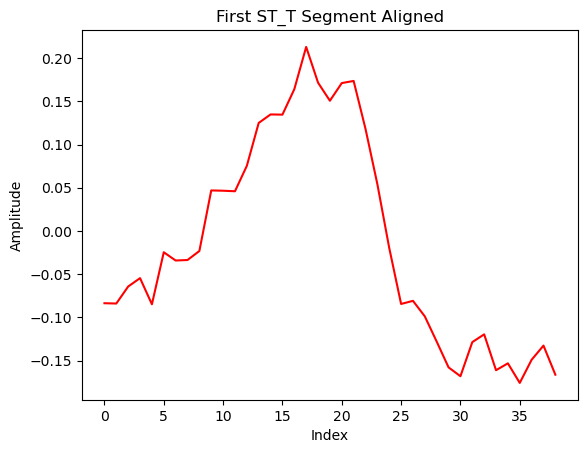

Name: nsrdb_18184_l2_s8.mat
Fs: 128
60
Name: nsrdb_18184_l2_s9.mat
Fs: 128
Name: nsrdb_19090_l2_s1.mat
Fs: 128
60
Name: nsrdb_19090_l2_s11.mat
Fs: 128
Name: nsrdb_19090_l2_s12.mat
Fs: 128
60
Name: nsrdb_19090_l2_s13.mat
Fs: 128
Name: nsrdb_19090_l2_s15.mat
Fs: 128
60
Name: nsrdb_19090_l2_s2.mat
Fs: 128
Name: nsrdb_19090_l2_s20.mat
Fs: 128
60
Name: nsrdb_19090_l2_s21.mat
Fs: 128
Name: nsrdb_19090_l2_s22.mat
Fs: 128
60
Name: nsrdb_19090_l2_s24.mat
Fs: 128
Name: nsrdb_19090_l2_s25.mat
Fs: 128
60
Name: nsrdb_19090_l2_s27.mat
Fs: 128
Name: nsrdb_19090_l2_s3.mat
Fs: 128
60
Name: nsrdb_19090_l2_s4.mat
Fs: 128
Name: nsrdb_19090_l2_s8.mat
Fs: 128
60
Name: nsrdb_19090_l2_s9.mat
Fs: 128
Name: nsrdb_19140_l1_s1.mat
Fs: 128
60
Name: nsrdb_19140_l1_s11.mat
Fs: 128
Name: nsrdb_19140_l1_s12.mat
Fs: 128
60
Name: nsrdb_19140_l1_s13.mat
Fs: 128
Name: nsrdb_19140_l1_s16.mat
Fs: 128
60
Name: nsrdb_19140_l1_s18.mat
Fs: 128
Name: nsrdb_19140_l1_s2.mat
Fs: 128
60
Name: nsrdb_19140_l1_s20.mat
Fs: 128
Name: nsr

In [13]:
WindSize = 32  # Analyze in blocks of 32 beats
WindStep = 8   # Each window contains 8 new beats---->  A menos windStep mayor coste computacional pero quizás mejor análisis
type_of_inclusion = 'alternate'
V_Alt_wave = 60  # muV
Fs = 128  # Hz
FILTERED_SIGNALS = []
for index,signal in enumerate(ALL_SIGNALS):
    #V_Alt_wave = random.randint(20, 70)
    #0. ADDITION OF ALTERNANTS---- FOR THIS STEP WE WILL NEED TO OBTAIN THE ST_T_onsets
    #We will proceed in the following way:
    #1- We calculate the ST_T_onsets for the ecg in the form we have it!!
    #2- We add the alternances to half of the signals.
    #3-Now we can perform the rest of the preprocessing
    if index % 2 == 0:
        print(V_Alt_wave)
        #WE ADD THE ALTERNANCE
        #We need to know in which sampling frequency are we!
        #AÑADIR LA ALTERNANCIA ADECUADA PARA CADA FS----> HAY ALTERNANCIAS PARA CADA FRECUENCIA DE MUESTREO!!!
        # Obtain the 'TWA_pattern' and 'ST_T_onset' corresponding to the current signal
        ST_T_complexes, ST_T_onset = ST_T_delineation(signal["Ecg"],signal["Qrs"], signal["Fs"][0][0])
        TWA_pattern = np.ones(signal["Qrs"].shape[1])
        
        #ADD THE ALTERNANCE
        
        ecg_with_TWA, alt_waves, Alternan_wave, alpha, Onset_Valt = alternant_wave_inclusion(
                                              signal["Ecg"], TWA_pattern, type_of_inclusion, ST_T_onset, V_Alt_wave, signal["Fs"][0][0])
        signal.update({"Ecg": ecg_with_TWA })

    #HAY QUE TENER CUIDADO CON EL VECTOR DE ANOTACIONES QRS---> SI HACEMOS DOWNSAMPLING ESE VECTOR DE POSICIONES SE PERDERÍA (CUIDADO!)
    print("Name:", signal["Name"])
    print("Fs:", signal["Fs"][0][0])
    #1. BASELINE WANDER ELIMINATION
    bw_estimate_clean = bw_elimination(signal["Ecg"][0, :], signal["Qrs"][0, :], signal["Fs"][0][0])  #the fiducial points son simplmente esos picos R (están en el qrs de las señales)
    clean_ecg_noBW = signal["Ecg"][0, :] - bw_estimate_clean + np.mean(bw_estimate_clean)
    signal.update({"Ecg":clean_ecg_noBW})
    
    #2.ST SEGMENTS OBTAINTION
    ST_T_complexes, ST_T_onset = ST_T_delineation(signal["Ecg"],signal["Qrs"], signal["Fs"][0][0])
    
    #3 ST SEGMENTS WINDOWING
    ST_T_segments, ST_T_onset_by_segments, _ = heartbeat_windowing(ST_T_complexes, ST_T_onset, WindSize, WindStep)
    if index == 500:
        print(ST_T_segments.shape)
    # 4 ST SEGMENTS DELINEATION
    NumbSegments = ST_T_segments.shape[2]
    #print(NumbSegments)

    # Step 1: Create an array of zeros to store the aligned ST-T segments
    ST_T_segments_aligned = np.zeros((WindSize, ST_T_segments.shape[1], NumbSegments))
    #Creamos un array de zeros to store---> WindSize = 32, El numero de complejos que es 39 y los segmentos que son 58
    # Step 2: Iterate over each segment
    for k in range(NumbSegments):
        # Step 3: Align the ST-T segment using ST_T_alignment function
        aligned_segment = ST_T_alignment(ST_T_segments[:,:,k], ST_T_onset_by_segments[k,:], signal["Ecg"], signal["Fs"][0][0])
        # Step 4: Store the aligned segment in the corresponding position of ST_T_segments_aligned
        ST_T_segments_aligned[:,:,k] = aligned_segment
    if index == 500:
        print(ST_T_segments_aligned)
        print(ST_T_segments_aligned.shape)
        #print the first complex from the first segment
        plt.plot(ST_T_segments_aligned[0,:,0], color = 'red')

        plt.xlabel('Index')
        plt.ylabel('Amplitude')


        plt.title('First ST_T Segment Aligned')

        plt.show()
        
    #5 BACKGORUND SUBSTRACTION
    ST_T_dif = np.zeros_like(ST_T_segments_aligned)
    for k in range(NumbSegments-1):
        ST_T_TensorBacGrElim = background_subtraction(ST_T_segments_aligned[:,:,k], WindSize)
        ST_T_dif[:,:,k] = ST_T_TensorBacGrElim
    #print(ST_T_dif)
    #print(ST_T_dif.shape)
    #6 LINEAR FILTERING
    ST_T_dif_filtered = filtering_ST_T_segments(ST_T_dif, signal["Fs"][0][0])
    
    signal.update({"ST_T_SEGMENTS": ST_T_dif_filtered })
    
    aux_signal_dict = {"Name": signal["Name"], "Fs" : signal["Fs"], "ST_T_SEGMENTS": ST_T_dif_filtered}
    if index == 1:    
        print(aux_signal_dict)
    #ADD THE DATA TO A FINAL DICTONARY WITH ALL THE SIGNALS
    FILTERED_SIGNALS.append(aux_signal_dict)
    #print(FILTERED_SIGNALS)

    #APLICAR DOWNSAMPLING O UPSAMPLING-----> PARA EL TEMA DE LA RED LSTM
    

        

In [14]:
ALL_SIGNALS[0]["Ecg"]

array([-0.96957986, -1.03471547, -1.0298496 , ..., -0.78456389,
       -0.8645714 , -0.97457986])

In [15]:
print(FILTERED_SIGNALS[573]["ST_T_SEGMENTS"].shape)

print(len(FILTERED_SIGNALS))
print(FILTERED_SIGNALS[52])

(32, 39, 188)
574
{'Name': 'edb_403_l1_s5.mat', 'Fs': array([[250]], dtype=uint8), 'ST_T_SEGMENTS': array([[[-3.85129881e-02,  9.30673085e-03, -1.88085361e-03, ...,
         -5.86890807e-03,  4.16539956e-04,  0.00000000e+00],
        [-4.63576072e-02,  1.13584575e-02, -2.30954711e-03, ...,
         -7.50703170e-03,  3.71764934e-04,  0.00000000e+00],
        [-5.36846330e-02,  1.31852151e-02, -2.85802295e-03, ...,
         -9.17737421e-03,  2.90820295e-04,  0.00000000e+00],
        ...,
        [-5.80243520e-03,  2.27473052e-02,  1.47808514e-02, ...,
          1.63202456e-02,  2.13627682e-02,  0.00000000e+00],
        [-5.61134077e-03,  1.81786118e-02,  1.18937073e-02, ...,
          1.33969999e-02,  1.73593179e-02,  0.00000000e+00],
        [-5.10250735e-03,  1.36046893e-02,  9.01543116e-03, ...,
          1.02909966e-02,  1.32211284e-02,  0.00000000e+00]],

       [[-2.91288161e-02,  3.68303579e-03, -4.35549334e-03, ...,
         -7.97762844e-03,  2.91491481e-03,  0.00000000e+00],
   

In [63]:
"""def numpy_to_list(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, int):
        return [[np.array(i)]]
    elif isinstance(obj, dict):
        return {k: numpy_to_list(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [numpy_to_list(v) for v in obj]
    else:
        return obj"""

In [64]:
e = 4
i = np.array(e)
print(e)

4


In [16]:
def numpy_to_list(arr):
    if isinstance(arr, np.ndarray):
        return arr.tolist()
    elif isinstance(arr, list):
        return [numpy_to_list(x) for x in arr]
    elif isinstance(arr, dict):
        return {key: numpy_to_list(value) for key, value in arr.items()}
    else:
        return arr

# Convertir arrays de NumPy en la estructura de datos antes de guardar en JSON
def convert_to_json_serializable(data):
    return numpy_to_list(data)
data = FILTERED_SIGNALS

# Convertir y guardar en JSON
with open('ALL_PREPROCESSED_SIGNALS_FINAL_60.json', 'w') as jsonfile:
    json.dump(convert_to_json_serializable(data), jsonfile)

In [65]:
"""import json

data = FILTERED_SIGNALS # Tu lista de diccionarios
#We create a json file to store all the information, so we do not need to proprocess the signals every time we work on them
with open('ALL_PREPROCESSED_SIGNALS_FINAL_CHANGEDAMPLITUDE.json', 'w') as jsonfile:
    json.dump(numpy_to_list(data), jsonfile)"""

TypeError: Object of type ndarray is not JSON serializable

In [17]:
with open("ALL_PREPROCESSED_SIGNALS_2.json", "r") as archivo:
    datos_cargados = json.load(archivo)

In [61]:
ee = np.array(datos_cargados[573]["ST_T_SEGMENTS"])

array([ 0.00743194,  0.00583525,  0.00347683,  0.00150203,  0.00092314,
        0.00208432,  0.00444569,  0.00683339,  0.0080496 ,  0.00750321,
        0.00550977,  0.00308551,  0.00137011,  0.00101811,  0.00191283,
        0.00334896,  0.00453249,  0.00507542,  0.00519199,  0.00551822,
        0.00671081,  0.00908685,  0.01248947,  0.01638541,  0.02006266,
        0.02277534,  0.02380786,  0.02252673,  0.01851848,  0.01182763,
        0.00316971, -0.00606223, -0.01409436, -0.01931217, -0.02081271,
       -0.01871811, -0.01409446, -0.00851982, -0.00351141])